## Setting up the libraries


In [ ]:
!pip uninstall -q -y tensorflow
!pip install -q tf-nightly

from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf

content_image = None


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.9/566.9 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.0 MB/s eta 0:00:00


### Download the style bottleneck and transfer networks, from TF Hub 🤖

In [ ]:
print('Downloading the model files...')

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/sayakpaul/lite-model/arbitrary-image-stylization-inceptionv3-dynamic-shapes/int8/predict/1?lite-format=tflite')
style_transform_path = style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/sayakpaul/lite-model/arbitrary-image-stylization-inceptionv3-dynamic-shapes/int8/transfer/1?lite-format=tflite')

print('Model files downloaded...')

9426610/9426610 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
2198322/2198322 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
Model files downloaded...


## Input image, from where the style will be copied from

In [ ]:
style_image_path = tf.keras.utils.get_file("IMG_6329.jpeg", 'https://raw.githubusercontent.com/vickybudhiraja/testvideos/main/IMG_6329.jpeg')

16962/16962 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Add your puppy's pictures 🐶 🐕

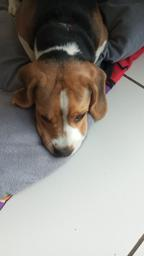

In [4]:
from IPython.display import display
import ipywidgets as widgets
from PIL import Image
import numpy as np
import io

clear_output()

def button_click(change):
    global content_image
    print('\n')
    img = Image.open(io.BytesIO(uploader.data[-1]))
    # saving the image in the global buffer var
    content_image = img

    # these lines of code are just to create thumbs of the images uploaded and render here! You can remove them if you want
    img = img.convert('RGB')
    img.thumbnail((256, 256))
    img.save('thumbnail.jpg')
    image = Image.open('thumbnail.jpg')
    display(image)

uploader = widgets.FileUpload()
show_button = widgets.Button(description='Load + Show image')
show_button.on_click(button_click)

widgets.VBox([widgets.Label('Upload a content image (must be an RGB or RGBA image). Make sure to press the ''load and show'' button & wait!'), uploader, show_button])

## Loading both <u>style-input</u> and <u>original-input</u> images
// Execute these cell, if you are re-uploading the input image

In [5]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
    img = tf.io.read_file(path_to_img)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]

    return img

# Function to load an image from a file, and add a batch dimension.
def load_content_img(image_pixels):
    if image_pixels.shape[-1] == 4:
        image_pixels = Image.fromarray(image_pixels)
        img = image_pixels.convert('RGB')
        img = np.array(img)
        img = tf.convert_to_tensor(img)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = img[tf.newaxis, :]
        return img
    elif image_pixels.shape[-1] == 3:
        img = tf.convert_to_tensor(image_pixels)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = img[tf.newaxis, :]
        return img
    elif image_pixels.shape[-1] == 1:
        raise Error('Grayscale images not supported! Please try with RGB or RGBA images.')
    print('Exception not thrown')

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
    # Resize the image so that the shorter dimension becomes 256px.
    shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
    short_dim = min(shape)
    scale = target_dim / short_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)

    # Central crop the image.
    image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

    return image

# Convert the content image from Bytes to NumPy array.
content_image = np.array(content_image)

# Load the input images.
content_image = load_content_img(content_image)
style_image = load_img(style_image_path)


Preprocessing the style and the content images...
Style image shape: (1, 256, 256, 3)
Content image shape: (1, 512, 512, 3)
Calculating style bottleneck...
Style Bottleneck Shape: (1, 1, 1, 100)
Stylizing image. It should not take more than three minutes...


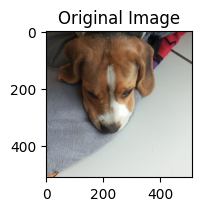

<Figure size 1000x1000 with 0 Axes>

In [6]:
# You're encouraged to play with the different values of `content_blending_ratio`.

#content_blending_ratio = 1 # min:0, max:1
content_image_size = 512 #min:192, max:512

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, content_image_size)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Preprocessing the style and the content images...')
print('Style image shape:', preprocessed_style_image.shape)
print('Content image shape:', preprocessed_content_image.shape)

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

    plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
imshow(preprocessed_content_image, 'Original Image')

# plt.subplot(1, 3, 2)
# imshow(preprocessed_style_image, 'Style Image')

# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
    # Load the model.
    interpreter = tf.lite.Interpreter(model_path=style_predict_path)

    # Set model input.
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

    # Calculate style bottleneck.
    interpreter.invoke()
    style_bottleneck = interpreter.tensor(interpreter.get_output_details()[0]["index"])()

    return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
print('Calculating style bottleneck...')
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)
print('Stylizing image. It should not take more than three minutes...')

# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
    # Load the model.
    interpreter = tf.lite.Interpreter(model_path=style_transform_path)

    # Set model input.
    input_details = interpreter.get_input_details()
    for index in range(len(input_details)):
        if input_details[index]["name"]=='content_image':
            index = input_details[index]["index"]
            interpreter.resize_tensor_input(index, [1, content_image_size, content_image_size, 3])
    interpreter.allocate_tensors()

    # Set model inputs.
    for index in range(len(input_details)):
        if input_details[index]["name"]=='Conv/BiasAdd':
            interpreter.set_tensor(input_details[index]["index"], style_bottleneck)
        elif input_details[index]["name"]=='content_image':
            interpreter.set_tensor(input_details[index]["index"], preprocessed_content_image)
    interpreter.invoke()

    # Transform content image.
    stylized_image = interpreter.tensor(
        interpreter.get_output_details()[0]["index"])()

    return stylized_image

# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
)

# Blend the style bottleneck of style image and content image
def setBlendingRatio(blendingRatio):
    style_bottleneck_blended = blendingRatio * style_bottleneck_content \
                            + (1 - blendingRatio) * style_bottleneck

    return style_bottleneck_blended



## How much style you want to copy from the source styled image?
The blending ratio

In [7]:
style_bottleneck_blended = setBlendingRatio(0.0)


## Render results! 😍

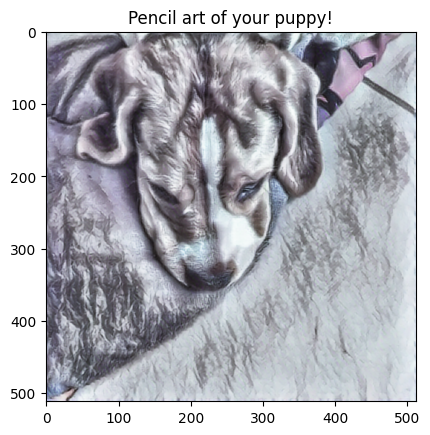

<Figure size 1000x1000 with 0 Axes>

In [8]:
# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck_blended, preprocessed_content_image)

# Visualize the output.
#plt.subplot(1, 3, 3)
imshow(stylized_image, 'Pencil art of your puppy!')

## Playing around! ⚽

In [9]:
style_bottleneck_blended = setBlendingRatio(1.0)

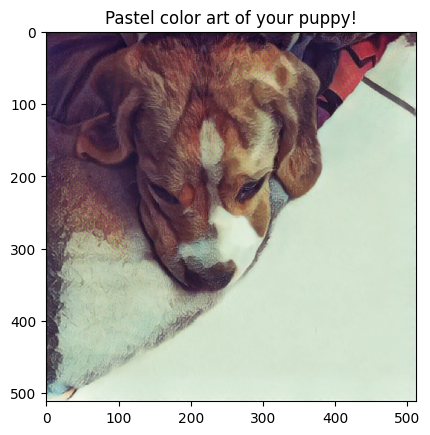

<Figure size 1000x1000 with 0 Axes>

In [10]:
# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck_blended, preprocessed_content_image)

# Visualize the output.
# plt.subplot(1, 3, 3)
imshow(stylized_image, 'Pastel color art of your puppy!')

This code is inspired by the Demo developed by [Sayak Paul](https://twitter.com/RisingSayak).